This notebook is for comparing SEI growth for electron-limited models in first and second order in the formation context. This is equivalent to Figure 5 in the manuscript.

In [1]:
# In the current released PyBaMM version, some models do not exist, which is why we need to run this locally.
%cd /home/kawamanmi/Projects/PyBaMM/src
import pybamm
import numpy as np

no_cycles = 2
exp = pybamm.Experiment(
    [("Charge at C/20 until 4.2 V",
      "Rest for 5 hours",
      "Discharge at C/20 until 2.5 V",
      "Rest for 5 hours",
      )]* no_cycles )


# For the purpose of this work, the SEI layer is considered as one layer here.
# However, in PyBaMM, some models consider it to grow on the inner side, some on the outer, and some as a single layer.
# To maintain consistency without changing the current PyBaMM version, we need to adjust some parameters for each model.
# To do this, we define a set of parameters for each model separately.

common_params = {
    'Initial inner SEI thickness [m]': 5e-13,
    'Initial outer SEI thickness [m]': 5e-13,
    'SEI kinetic rate constant [m.s-1]': 7.0e-13,
    'Outer SEI solvent diffusivity [m2.s-1]': 1e-14,
    'Bulk solvent concentration [mol.m-3]': 4541.0,
    'Inner SEI electron conductivity [S.m-1]': 8.95e-15,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    'Inner SEI lithium interstitial diffusivity [m2.s-1]': 1e-20,
    'Lithium interstitial reference concentration [mol.m-3]': 1000,
    'Tunneling barrier factor [m-1]': 1/2.0e-9,
    'tunneling distance for electrons [m]': 0,
    'SEI reaction exchange current density [A.m-2]': 0.0003,
    'Inner SEI open-circuit potential [V]': 0.4,
}

params = []

# Create and update parameters for both cases
for inner_sei_reaction_proportion in [1, 0, 1, 1]:
    param = pybamm.ParameterValues("Chen2020")
    param.update({**common_params, 'Inner SEI reaction proportion': inner_sei_reaction_proportion}, check_already_exists=False)
    params.append(param)



# setup pybamm model to includ SEI models as well "electron-migration limited", "interstitial-diffusion limited", "tunnelling limited" , "Kolzenberg2020"
sei_options = [ "electron-migration limited", "interstitial-diffusion limited", "tunnelling limited", "Kolzenberg2020"]


models = [pybamm.lithium_ion.SPM({"particle": "uniform profile",
                                  "SEI": sei_option}) for sei_option in sei_options]

pybamm.settings.max_y_value = 100000000
solver = pybamm.CasadiSolver(mode="safe")

sims = [pybamm.Simulation(model, parameter_values=params[index],
                          experiment=exp, solver=solver) for index, model in enumerate(models)]
sols = [sim.solve(initial_soc=0) for sim in sims]


/home/kawamanmi/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/kawamanmi/Projects/PyBaMM/src


/home/kawamanmi/Projects/formation/zero-dimension-comparison-SEI/tests/user_tests


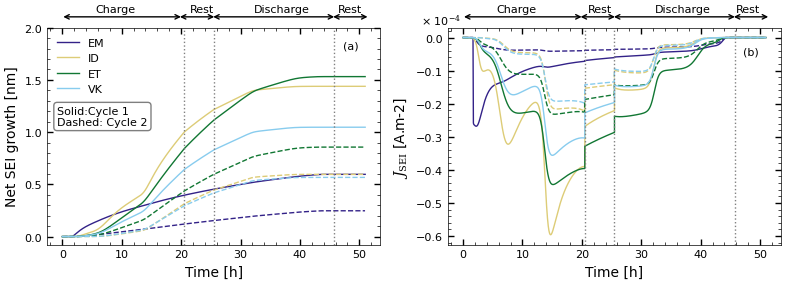

In [2]:
# %cd -
%cd /home/kawamanmi/Projects/formation/zero-dimension-comparison-SEI/tests/user_tests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scienceplots
import matplotlib.ticker as ticker
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from style_figs import set_plotting_format

set_plotting_format("paper")  # input should be either "presentation" or "paper"

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

label_models = [
'EM',
'ID',
'ET',
"VK"
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
line_styles = ['-', '--']
# First plot
for index, sol in enumerate(sols):
    color = colors[(1+index) % len(colors)]
    for cycle in range(no_cycles):
        t_min = np.min(sol.cycles[cycle]["Time [h]"].entries)
        t = sol.cycles[cycle]["Time [h]"].entries - t_min
        L_min = np.min(sol.cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries)
        L_sei = (sol.cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries - L_min) * 1e9
        if (cycle == 0):
            axes[0].plot(t, L_sei,  label=label_models[index], color=color, linestyle=line_styles[cycle % 2])
        else:
            axes[0].plot(t, L_sei,  color=color, linestyle=line_styles[cycle % 2])

axes[0].set_yticks(np.linspace(0, 2, 5))
axes[0].set_xlabel("Time [h]")
axes[0].set_ylabel("Net SEI growth [nm]")
axes[0].legend()
axes[0].text(0.03, 0.55, 'Solid:Cycle 1\nDashed: Cycle 2',
            transform=axes[0].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

axes[0].axvline(x=20.5, color='grey', linestyle=':', linewidth=1)
axes[0].axvline(x=25.5, color='grey', linestyle=':', linewidth=1)
axes[0].axvline(x=45.7, color='grey', linestyle=':', linewidth=1)
axes[0].text(9, 2.15, 'Charge', ha='center')
axes[0].text(23.5, 2.15, 'Rest', ha='center')
axes[0].text(37, 2.15, 'Discharge', ha='center')
axes[0].text(48.5, 2.15, 'Rest', ha='center')
axes[0].text(48.5, 1.8, '(a)', ha='center')

axes[0].annotate('', xy=(0.04, 1.05), xytext=(0.41, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[0].annotate('', xy=(0.39, 1.05), xytext=(0.51, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[0].annotate('', xy=(0.49, 1.05), xytext=(0.87, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[0].annotate('', xy=(0.85, 1.05), xytext=(0.97, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))

# Second plot
for index, sol in enumerate(sols):
    color = colors[(1+index) % len(colors)]
    for cycle in range(no_cycles):
        t_min = np.min(sol.cycles[cycle]["Time [h]"].entries)
        t = sol.cycles[cycle]["Time [h]"].entries - t_min
        J_sei_last = sol.cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries[0]
        J_sei = sol.cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries - J_sei_last * 0
        axes[1].plot(t, J_sei * 1e4, color=color, linestyle=line_styles[cycle % 2])
        # axins.plot(t, J_sei * 1e4, color=color, linestyle=line_styles[cycle % 2])

# Add vertical lines and text at the top of the x-axis for the second plot
axes[1].axvline(x=20.5, color='grey', linestyle=':', linewidth=1)
axes[1].axvline(x=25.5, color='grey', linestyle=':', linewidth=1)
axes[1].axvline(x=45.7, color='grey', linestyle=':', linewidth=1)
axes[1].text(9, 0.077, 'Charge', ha='center')
axes[1].text(23, 0.077, 'Rest', ha='center')
axes[1].text(37, 0.077, 'Discharge', ha='center')
axes[1].text(48,0.077, 'Rest', ha='center')
axes[1].text(48.5, -0.05, '(b)', ha='center')

axes[1].annotate('', xy=(0.04, 1.05), xytext=(0.41, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[1].annotate('', xy=(0.39, 1.05), xytext=(0.51, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[1].annotate('', xy=(0.49, 1.05), xytext=(0.87, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[1].annotate('', xy=(0.85, 1.05), xytext=(0.97, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))


axes[1].set_xlabel("Time [h]")
axes[1].set_ylabel(
    "$J_\mathrm{SEI}$ [A.m-2] ")
axes[1].text(-0.08, 1.07, '× 10$^{-4}$', transform=axes[1].transAxes,
             verticalalignment='top')


plt.tight_layout()
plt.savefig("figs/electron_limited.png", dpi=300)